# Example


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from measuremelt import luminance, count
from measuremelt import load

### Video Material

Image data was published as data set at the [VHub](https://vhub.org) platform. Videos of each run are published as separate dataset.
  - `pr06`: https://vhub.org/resources/4211
  - `pr05`: https://vhub.org/resources/4237
  - `ir16`: https://vhub.org/resources/4240
  - `ir15`: https://vhub.org/resources/4246
  - `ir14`: https://vhub.org/resources/4261
  - `ir13`: https://vhub.org/resources/4270
  - `ir12`: https://vhub.org/resources/4279
  - `ir07`: https://vhub.org/resources/4289
  - `ir06`: https://vhub.org/resources/4293
  - `ir05`: https://vhub.org/resources/4299
  - `ir04`: https://vhub.org/resources/4306
  - `ir03`: https://vhub.org/resources/4313


`load.show()` lists the videos that were already analyzed. `load.show(url=True)` will also print the corresponding download urls of each video.

In [3]:
load.show()

run   cam   
---   ---   
pr06  casio-f1  
pr06  rx100v  
pr06  pco  
pr05  sony-4k2  
pr05  rx100v  
ir16  casio-f1  
ir15  casio-f1  
ir14  casio-f1  
ir13  casio-f1  
ir12  casio-f1  
ir07  sony-4k1  
ir07  sony-4k2  
ir06  casio-f1  
ir05  casio-f1  
ir04  casio-f1  
ir03  casio-f1  
tx02  nac  
tx08  nac  



### Create an image sequence from the video file

To ease the download/file naming process, the `load.imseq()` function will test if the video data of a specific experiment (`run`) and camera is already present on the system (i.e. in the `data/` folder). If that is not the case, it will download the video file from VHub, create ana ppropriate folder, and convert it to an image sequence using `ffmpeg` with the following command
```bash
ffmpeg -i data/run_cam.mp4 -q:v 1 data/run_cam/frame%08d.jpg
```
The original video file or zip archives will not be removed after the sequence is created. 
> **note on file and folder names**: We started working with camera names containing the manufacturer, since this is easy to start with. For a publication this is however not optimal. Therefore, some (later) uploaded video material contains a different camera label. During dowload the `load.ipseq()` function prints out a line containing the file name on disk. Also, the [dataset pages on VHub](#Video-material) listed above have the explicit video name convention explicitely listed.

Be aware that some video material may be large (>1GB). The `casio-f1` file of the `pr06` run will only use about 200MB disk space:

In [4]:
seq = load.imgseq(run='pr06', cam='casio-f1')

In [5]:
seq.frame_shape

(384, 512, 3)

Once the image sequence is present on the hard disk `load.imseq()` will skip the download and convertion steps and just return the
sequence (`pims.ImageSequence`) object. This can be made explicit by replacing the above call with the following line and un-comment
line \#4 of the very first cell of this notebook that contains the import statements. Adjusting the path specification may also be
necessary. The two pipeline methods `as_grey` and `lambda` float conversion are necessary for gray scale import and easy behavior in the
analysis.

Frame([[ 84.8216, 107.5332, 133.4593, ...,  81.0475,  96.4763,  95.4763],
       [ 91.8216, 112.5332, 106.4593, ...,  56.0475,  61.0475,  66.0475],
       [118.6774, 111.1044,  82.3151, ...,  70.4004,  65.4004,  70.4004],
       ...,
       [109.852 , 108.852 , 139.852 , ...,   4.573 ,  11.6451,  25.6451],
       [117.852 ,  96.852 ,  78.852 , ...,   0.2884,  15.6451,  38.6451],
       [118.852 , 100.852 ,  71.852 , ...,   0.2884,  13.6451,  35.6451]])
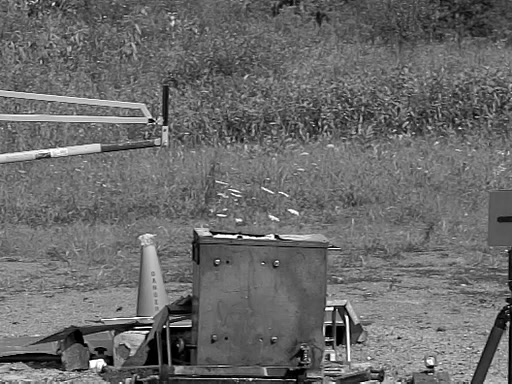

In [6]:
seq[0]

#### spatial resolution

Width of container top is 51 cm in real space, 129 px on image frame.

In [7]:
res = .51 / 129

#### Melt brightness

That should be measured from a typical melt 'domain' that shows no sign of motion blur. The measurement tool of ImageJ is the quickes way to do that.

In [8]:
bmelt = 175.

#### Field of view

Visible area is the images resolution multiplied by the images width $W$ and height $H$

$$
S_c = a^2\,W\,H
$$

In [9]:
H, W = seq[0].shape
Sc = res ** 2 * W * H
Sc

3.0729968631692817

Cumulative melt brightness is the brightness that would be measures if only melt was visible in the image, therefore

In [10]:
Bmelt = W * H * bmelt

#### Background noise

Take all frames before start of water injection to compute the average brightness of that interval. This is the beckground noise. In this video injection starts at frame 94, when the sync light turns on.

In [11]:
B0 = luminance.average_cbright(seq[:94])

## Luminanace

$$
L = S_c\,\frac{B - B_0}{B_{melt} - B_0}
$$

In [12]:
L = luminance.luminance_sequence(seq, Sc, Bmelt, B0)

### Time axis

A time array that is 0 at water injection start, with time steps matching those of the video frame rate.

In [13]:
seq.frame_shape

(384, 512, 3)

In [14]:
fps = 300
t = np.linspace(-94 / fps, (len(L) - 94) / fps, len(L))

Plot result

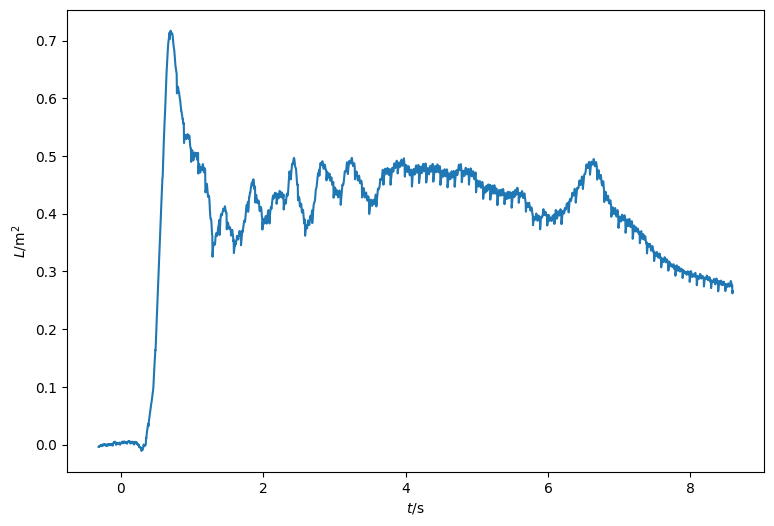

In [15]:
plt.figure(figsize=(9, 6))
plt.plot(t, L)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L/\mathrm{m^2}$');

## Optional Functionality

### The `select` switch: Compute $L$ for a selection

To improve the signal-to-noise ratio, $L$ can be computed from a subset of each frame. That selection is the same for all frames in the sequence. The format is `((vertical start, vertical end), (horizontal start, horizontal end))`

Frame([[ 74.9604,  85.8162, 101.097 , ...,  64.9888,  83.0609,  66.0609],
       [ 66.8162,  77.672 ,  94.097 , ...,  70.9888,  80.0609,  83.0609],
       [ 82.5258,  92.097 ,  87.097 , ...,  71.9888,  70.9888,  71.9888],
       ...,
       [118.7263,  85.5687,  91.0524, ..., 102.6205, 102.6205,  86.6205],
       [117.2234,  78.7754,  79.2591, ..., 127.2676, 139.2676, 122.2676],
       [ 94.1455,  67.6975,  87.6783, ...,  71.4118,  78.4118,  72.2676]])
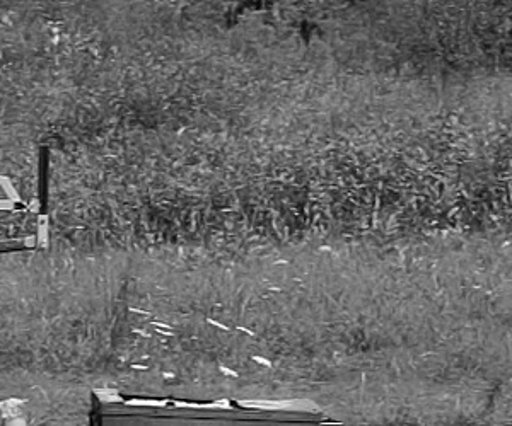

In [16]:
sel = ((0, 250), (140, 440))

seq[0][slice(*sel[0]), slice(*sel[1])]

Per pixel values stay unchanges. Cumulative values ($B_{melt}, B_0$) have to be re-computed.

In [17]:
H1, W1 = 250, 300
Bmelt1 = H1 * W1 * bmelt
Sc1 = H1 * W1 * res ** 2
Sc1

1.172255273120606

The functions of the `luminance` module have a `select` switch, where appropriate, which use the above format.

In [18]:
B01 = luminance.average_cbright(seq[:94], select=sel)
L1 = luminance.luminance_sequence(seq, Sc1, Bmelt1, B01, select=sel)

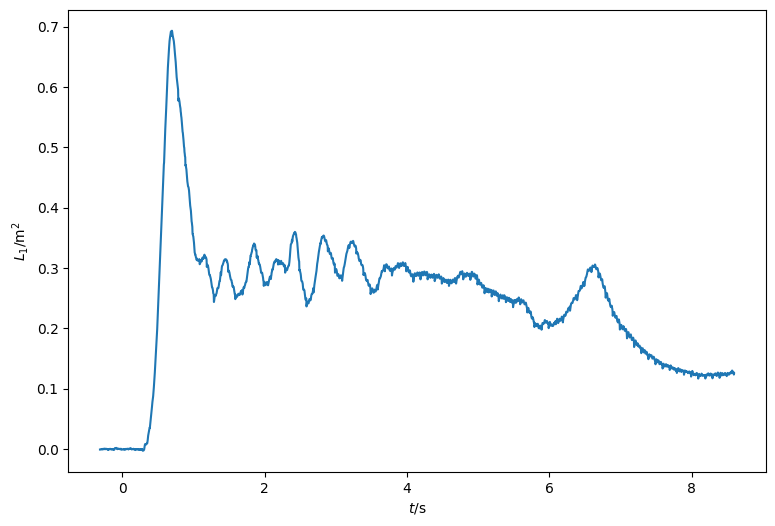

In [19]:
plt.figure(figsize=(9, 6))
plt.plot(t, L1)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L_1/\mathrm{m^2}$');

### Propagation of Uncertainties / Measurement Errors

Image resolutions $a$ (`res` in the code)
$$
a = \frac{x}{X}\quad,
$$
where $x$ is a known length in real space, measured for example in meters, and $X$ is the same length on the camera's chip, measured in px. In this example the container width is known to be $x=0.51\,\mathrm{m}$ wide, and the accuracy is about $\pm2\,\mathrm{mm}$. In the image sequence the container width is $X=129\,\mathrm{px}$, and the accuracy there is about $\pm1\,\mathrm{px}$.

$$
\sigma_{a}^2 = a^2\,\Bigl(\frac{\sigma_x^2}{x^2} + \frac{\sigma_X^2}{X^2}\Bigr)
$$

In [20]:
σres = res * np.sqrt((2e-3 / 0.51) ** 2 + (1 / 129.1) ** 2)
res, σres

(0.003953488372093024, 3.432442750449686e-05)

The camera specific melt brightness of one pixel is ${b_{melt}=175}{}$ (no units here). Playing around with a suitable averaging area shows that this value typically changes by about ${\sigma_{b_{melt}}=\pm5}$. 
$$
\sigma_{B_{melt}} = \sigma_{b_{melt}}\frac{B_{melt}}{b_{melt}}
$$

In [21]:
σbmelt = 5.
σBmelt = σbmelt * Bmelt / bmelt
σBmelt

983040.0

Error of $S_c$:

$$
\sigma_{S_c} = 2S_c\,\frac{\sigma_{a}}{a}
$$

In [22]:
σSc = 2 * Sc * σres / res
σSc

0.05335989289659072

Uncertainty for the background level (noise) $B_0$ comes from the temporal changes during the averaging period (here during the first 94 frames of the image sequence. The `average_cbright()` function has an `uncert` switch. When set to `True` a tuple of $B_0$ and its standard deviation is returned.

In [23]:
B0, σB0 = luminance.average_cbright(chunk=seq[:94], uncert=True)
B0, σB0

(21131641.751661707, 8800.340692610851)

Luminances uncertainty is evaluated as:
$$
\sigma_L^2 = \biggl(\frac{L}{B_{melt}-B_0}\biggr)^2 \sigma_{B_{melt}}^2 +
\biggl(\frac{L - 1}{B_{melt}-B_0}\biggr)^2\sigma_{B_0}^2 +
\biggl(\frac{L}{S_c}\biggr)^2\sigma_{S_c}^2
\quad,
$$
and is available as function `sigma_luminance()`, that returns an array with uncertainties for each frame it was given in the `lum` parameter.

In [24]:
σL = luminance.sigma_luminance(
    lum=L, ref=Bmelt, sref=σBmelt, noise=B0, snoise=σB0, fov=Sc, sfov=σSc)

A plot with the standard deviation as gray shadow:

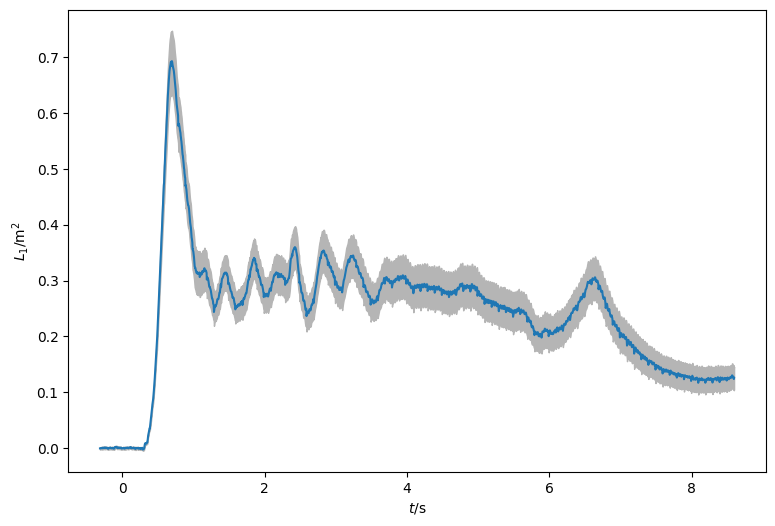

In [25]:
plt.figure(figsize=(9, 6))
plt.fill_between(t, L1 + σL, L1 - σL, color='#b5b5b5')
plt.plot(t, L1)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L_1/\mathrm{m^2}$');

## Boolean Count-Based Melt Area

### Simple Luminance Threshold

This is more tricky compared to the 'luminance' based method. The Black \& White example
shows some caveats.

In [26]:
thr = 150

In [27]:
np.where(t>8)[0][0]

2494

In [28]:
endframes = np.asarray([frm for frm in seq[2494:]])

In [29]:
avg = count.average_count(
    seq[2494:], select=sel,
    count_func=count.threshold, func_args=(thr, False)
)
avg

1790.0224719101125

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
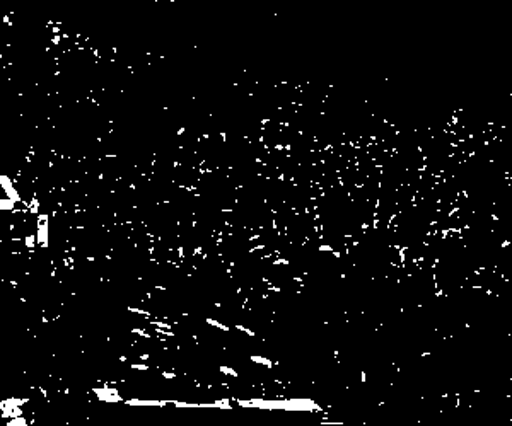

In [30]:
cnt, frame = count.threshold(
    seq[50][slice(*sel[0]), slice(*sel[1])], thr, True)
test = np.asanyarray(frame, dtype=int)
test

In [31]:
seq[250][0:250, sel[1][0]:sel[1][1]]

Frame([[ 82.6055,  98.6055,  95.0343, ...,  62.9812,  83.9812,  63.9812],
       [ 68.4613,  79.4613,  89.6055, ...,  73.9812,  78.9812,  87.9812],
       [ 78.3892,  80.3892,  85.4613, ...,  71.1254,  63.1254,  81.1254],
       ...,
       [117.7225,  87.4187,  89.3274, ...,  98.1176,  91.1897,  91.1897],
       [116.2196,  76.9158,  77.8245, ..., 132.1897, 134.3339, 127.3339],
       [115.0734,  76.1946,  84.8908, ...,  70.7627,  67.7627,  66.7627]])

In [32]:
Sc1

1.172255273120606

In [33]:
melt_count = count.area_sequence(
    seq, Sc1, avg, select=sel,
    count_func=count.threshold, func_args=(thr, False)
)

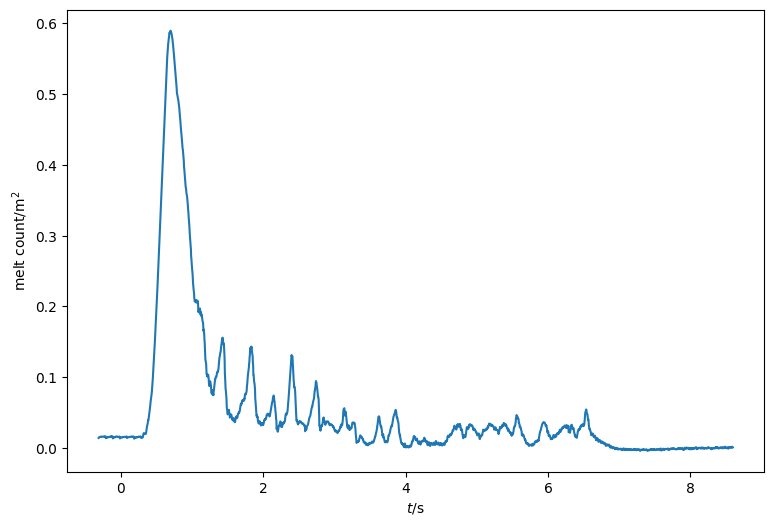

In [34]:
plt.figure(figsize=(9, 6))
plt.plot(t, melt_count)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'melt count$/\mathrm{m^2}$');

### Threshold and Channel Ratio Based Melt Detection

The function `count.thr_lum_to_ch()` allows to specify a luminance threshold and a ratio
of luminance and one of the three RGB channels (0, 1, 2). All pixels with luminance larger
than parameter `thr_lum` for which ratio of luminance and the specified channel is *smaller*
than `lum_to_ch` is counted.

In [35]:
selsl = (slice(*sel[0]), slice(*sel[1]))
selsl

(slice(0, 250, None), slice(140, 440, None))

In [36]:
seqc = load.imgseq(run='pr06', cam='casio-f1', gray=False)

In [37]:
thr_l = 130
ltr = .93

In [38]:
avg = count.average_count(
    seqc[2494:], select=sel,
    count_func=count.thr_lum_to_ch, func_args=(thr_l, ltr, 0, False)
)
avg

545.5505617977528

- frames with melt: `250, 280`
- frames at end: > `2494`

In [39]:
cnt, frame = count.thr_lum_to_ch(
    seqc[0][selsl], thr_l, ltr, 0, True)
test = np.asanyarray(frame, dtype=int)
test

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Frame([[[ 81.,  78.,  27.],
        [ 92.,  89.,  36.],
        [109., 104.,  49.],
        ...,
        [ 65.,  67.,  45.],
        [ 83.,  85.,  64.],
        [ 66.,  68.,  47.]],

       [[ 73.,  70.,  17.],
        [ 84.,  81.,  26.],
        [102.,  97.,  42.],
        ...,
        [ 71.,  73.,  51.],
        [ 80.,  82.,  61.],
        [ 83.,  85.,  64.]],

       [[ 91.,  85.,  33.],
        [100.,  95.,  40.],
        [ 95.,  90.,  35.],
        ...,
        [ 72.,  74.,  52.],
        [ 71.,  73.,  51.],
        [ 72.,  74.,  52.]],

       ...,

       [[140., 115.,  93.],
        [112.,  81.,  53.],
        [124.,  85.,  54.],
        ...,
        [108., 103.,  83.],
        [108., 103.,  83.],
        [ 92.,  87.,  67.]],

       [[140., 113.,  92.],
        [109.,  73.,  47.],
        [116.,  72.,  43.],
        ...,
        [131., 128., 109.],
        [143., 140., 121.],
        [126., 123., 104.]],

       [[120.,  89.,  69.],
        [101.,  61.,  36.],
        [129.,  79.,  52.],
        ...,
        [ 75.,  72.,  55.],
        [ 82.,  79.,  62.],
        [ 76.,  73.,  54.]]])
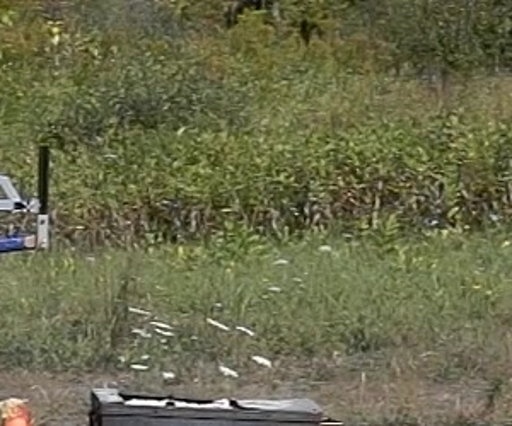

In [40]:
seqc[0][selsl]

#### Save an image sequence of binary maps and stich them into a video

If the video file `data/pr06_c2_detected-melt.webm` does not yet exist on the system it can be created by
uncommenting/converting the following two cells to code cells and executing them.

<div align="center">
    <video controls width="67%" src="data/pr06_c2_detected-melt.webm"></video>
</div>

#### Melt Area Time Dependency

In [41]:
melt_count = count.area_sequence(
    seqc, Sc1, avg, select=sel,
    count_func=count.thr_lum_to_ch, func_args=(thr_l, ltr, 0, False)
)

In [42]:
melt_count.min()

-0.001583128035625176

In [43]:
melt_count[melt_count < 0.] = 0.

In [44]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(t, melt_count)
ax.set(xlabel=r'$t/\mathrm{s}$', ylabel=r'melt count$/\mathrm{m^2}$');